<a href="https://colab.research.google.com/github/aaronjoel/ML_Sebastian_Raschka_Notebooks_Exercises/blob/main/pytorch_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install watermark --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00


In [ ]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch: 2.3.0+cu121



## Autograd Example

In [14]:
import torch
from torch.autograd import grad
import torch.nn.functional as F

In [15]:
x = torch.tensor([3.0])
w = torch.tensor([2.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)
a = F.relu(x*w + b)

In [16]:
a

tensor([7.], grad_fn=<ReluBackward0>)

In [17]:
grad(a, w, retain_graph=True)   # derivative of a with respect to w

(tensor([3.]),)

In [18]:
grad(a, b)

(tensor([1.]),)

In [19]:
x = torch.tensor([3.])
w = torch.tensor([2.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

def my_relu(z):
  if z > 0.:
    return z
  else:
    z[:] = 0.
    return z

a = my_relu(x*w + b)
grad(a, w)

(tensor([3.]),)

In [20]:
z = x*w + b
z

tensor([7.], grad_fn=<AddBackward0>)

In [21]:
my_relu(z)

tensor([7.], grad_fn=<AddBackward0>)

In [24]:
x = torch.tensor([-1.])
w = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

def my_relu(z):
  if z > 0.:
    return z
  else:
    z[:] = 0.
    return z

In [25]:
a = F.relu(x*w + b)
a

tensor([0.], grad_fn=<ReluBackward0>)

In [26]:
grad(a, w, retain_graph=False)

(tensor([-0.]),)

In [28]:
a

tensor([0.], grad_fn=<ReluBackward0>)

In [29]:
import torch
from torch.autograd import grad
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
import pandas as pd

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss21/main/L06/code/datasets/iris.data', index_col=None, header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [32]:
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
df.head()

,x1,x2,x3,x4,y
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [33]:
df = df.iloc[50:150]
df.head()

,x1,x2,x3,x4,y
50,7.0,3.2,4.7,1.4,Iris-versicolor
51,6.4,3.2,4.5,1.5,Iris-versicolor
52,6.9,3.1,4.9,1.5,Iris-versicolor
53,5.5,2.3,4.0,1.3,Iris-versicolor
54,6.5,2.8,4.6,1.5,Iris-versicolor


In [34]:
df['y'] = df['y'].apply(lambda x: 0 if x == 'Iris-versicolor' else 1)
df.head()

,x1,x2,x3,x4,y
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


In [35]:
# Assign features and target
X = torch.tensor(df[['x2', 'x3']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0) * 0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [36]:
X_test.mean(0), X_test.std(0)

(tensor([ 0.0873, -0.0719]), tensor([0.8478, 1.1928]))

# 1) ADALINE Manually

In [53]:
class Adaline1():
  def __init__(self, num_features):
    self.num_features = num_features
    self.weight = torch.zeros(num_features,1,dtype=torch.float)

    self.bias = torch.zeros(1, dtype=torch.float)

  def forward(self, x):
    net_inputs = torch.add(torch.mm(x, self.weight), self.bias)
    activations = net_inputs
    return activations.view(-1)

  def backward(self, x, yhat, y):

    grad_loss_yhat = 2 * (y - yhat)

    grad_yhat_weights = -x

    grad_yhat_bias = -1.

    # Chain rule: inner times outer
    grad_loss_weights = torch.mm(grad_yhat_weights.t(), grad_loss_yhat.view(-1, 1)) / y.size(0)

    grad_loss_bias = torch.sum(grad_yhat_bias * grad_loss_yhat) / y.size(0)

    return -grad_loss_weights, -grad_loss_bias


#####################################################
# Training and evaluation wrappers
#####################################################
def loss_func(yhat, y):
  return torch.mean((yhat - y) ** 2)

def train(model, x, y, num_epochs, learning_rate=0.01,
          seed=123, minibatch_size=10):
  cost = []

  torch.manual_seed(seed)

  for e in range(num_epochs):
    ## Shuffle epoch
    shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
    minibatches = torch.split(shuffle_idx, minibatch_size)

    for minibatch_idx in minibatches:
      ## Compute outputs
      yhat = model.forward(x[minibatch_idx])

      ## Compute gradients
      negative_grad_w, negative_grad_b = model.backward(x[minibatch_idx],
                                                        yhat,
                                                        y[minibatch_idx])

      ## Update weights
      model.weight += learning_rate * negative_grad_w
      model.bias += learning_rate * negative_grad_b

    ## Logging
    yhat = model.forward(x)
    curr_loss = loss_func(yhat, y)
    print(f'Epoch: {e+1:03d} | MMSE: {curr_loss:.5f}')
    cost.append(curr_loss)

  return cost

In [54]:
X_train.shape[1]

2

In [55]:
model = Adaline1(num_features=X_train.size(1))


In [56]:
cost = train(model,
             X_train,
             y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MMSE: 0.38849
Epoch: 002 | MMSE: 0.31679
Epoch: 003 | MMSE: 0.26379
Epoch: 004 | MMSE: 0.22463
Epoch: 005 | MMSE: 0.19527
Epoch: 006 | MMSE: 0.17307
Epoch: 007 | MMSE: 0.15629
Epoch: 008 | MMSE: 0.14352
Epoch: 009 | MMSE: 0.13360
Epoch: 010 | MMSE: 0.12600
Epoch: 011 | MMSE: 0.12007
Epoch: 012 | MMSE: 0.11547
Epoch: 013 | MMSE: 0.11178
Epoch: 014 | MMSE: 0.10884
Epoch: 015 | MMSE: 0.10656
Epoch: 016 | MMSE: 0.10470
Epoch: 017 | MMSE: 0.10320
Epoch: 018 | MMSE: 0.10200
Epoch: 019 | MMSE: 0.10105
Epoch: 020 | MMSE: 0.10025


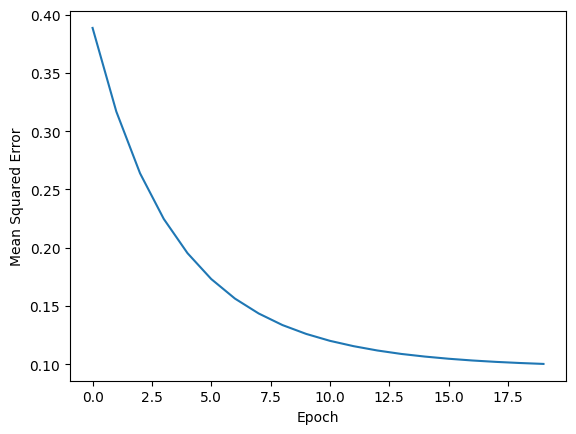

In [57]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [58]:
ones = torch.ones(y_train.size())
ones

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [59]:
y_train.size()

torch.Size([70])

In [60]:
zeros = torch.zeros(y_train.size())
zeros

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
train_pred = model.forward(X_train)

In [62]:
torch.where(train_pred > 0.5, ones, zeros)

tensor([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])

In [63]:
torch.where(train_pred > 0.5, ones, zeros).int() == y_train

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,  True])

In [64]:
(torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float()

tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.])

In [65]:
torch.mean(
    (torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float()
)

tensor(0.9286)

In [66]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float()
)

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())

test_pred = model.forward(X_test)

test_acc = torch.mean(
    (torch.where(test_pred > 0.5, ones, zeros).int() == y_test).float()
)

print(f'Training Accuracy: {train_acc*100:.2f}')
print(f'Test Accuracy:     {test_acc*100:.2f}')

Training Accuracy: 92.86
Test Accuracy:     93.33


# 2) ADALINE Semi-Manullay (using Autograd)

In [67]:
class Adaline2():
  def __init__(self, num_features):
    self.num_features = num_features
    self.weight = torch.zeros(num_features, 1,
                              dtype=torch.float,
                              requires_grad=True)

    self.bias = torch.zeros(1, dtype=torch.float, requires_grad=True)

  def forward(self, x):
    net_inputs = torch.add(torch.mm(x, self.weight), self.bias)
    activations = net_inputs
    return activations.view(-1)

In [72]:
def loss_func(yhat, y):
  return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs, learning_rate=0.01, seed=123, minibatch_size=10):
  cost = []

  torch.manual_seed(seed)

  for e in range(num_epochs):

    ## Shuffle data for epoch
    shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
    minibatches = torch.split(shuffle_idx, minibatch_size)

    for minibatch_idx in minibatches:
      ## Compute outputs
      yhat = model.forward(x[minibatch_idx])
      loss = loss_func(yhat, y[minibatch_idx])

      ## Compute gradients
      negative_grad_w = grad(loss, model.weight, retain_graph=True)[0] * (-1)
      negative_grad_b = grad(loss, model.bias)[0] * (-1)

      ## Update weights
      model.weight = model.weight + learning_rate * negative_grad_w
      model.bias = model.bias + learning_rate * negative_grad_b

    ## Logging
    with torch.no_grad():
      # Context manager to
      # avoid building graph during 'inference'
      # to save memory
      yhat = model.forward(x)
      curr_loss = loss_func(yhat, y)
      print(f"Epoch: {e+1:03d} | MSE: {curr_loss:.5f}")
      cost.append(curr_loss)

  return cost



In [73]:
model = Adaline2(num_features=X_train.size(1))

cost = train(model,
             X_train,
             y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 0.38849
Epoch: 002 | MSE: 0.31679
Epoch: 003 | MSE: 0.26379
Epoch: 004 | MSE: 0.22463
Epoch: 005 | MSE: 0.19527
Epoch: 006 | MSE: 0.17307
Epoch: 007 | MSE: 0.15629
Epoch: 008 | MSE: 0.14352
Epoch: 009 | MSE: 0.13360
Epoch: 010 | MSE: 0.12600
Epoch: 011 | MSE: 0.12007
Epoch: 012 | MSE: 0.11547
Epoch: 013 | MSE: 0.11178
Epoch: 014 | MSE: 0.10884
Epoch: 015 | MSE: 0.10656
Epoch: 016 | MSE: 0.10470
Epoch: 017 | MSE: 0.10320
Epoch: 018 | MSE: 0.10200
Epoch: 019 | MSE: 0.10105
Epoch: 020 | MSE: 0.10025


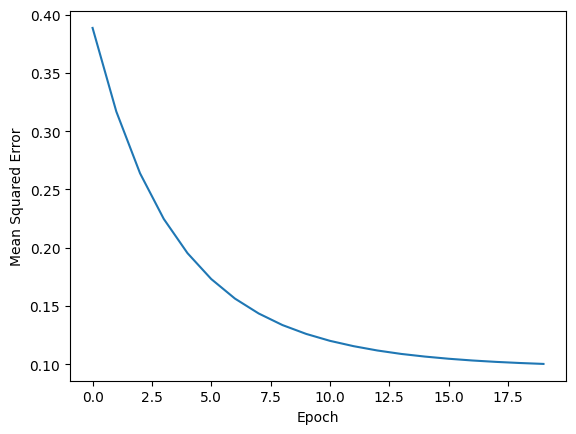

In [74]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [75]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, ones, zeros).int() == y_train).float()
)

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, ones, zeros).int() == y_test).float()
)

print(f'Training Accuracy: {train_acc*100:.2f}')
print(f'Test Accuracy:     {test_acc*100:.2f}')

Training Accuracy: 92.86
Test Accuracy:     93.33


In [77]:
class Adaline3(torch.nn.Module):
  def __init__(self, num_features):
    super(Adaline3, self).__init__()
    self.linear = torch.nn.Linear(num_features, 1)

    # change random weights to zero
    # (don't do this for multi-layer nets!)
    self.linear.weight.detach().zero_()
    self.linear.bias.detach().zero_()

  def forward(self, x):
    net_inputs = self.linear(x)
    activations = net_inputs
    return activations.view(-1)

In [78]:
def train(model, x, y, num_epochs, learning_rate=0.01, seed=123, minibatch_size=10):
  cost = []

  torch.manual_seed(seed)

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  for e in range(num_epochs):
    ## Shuffle data indices
    shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
    minibatches = torch.split(shuffle_idx, minibatch_size)

    for minibatch_idx in minibatches:
      ## Compute outputs
      yhat = model.forward(x[minibatch_idx])

      # You could also user our "manual"loss_fun
      #loss = loss_func(yhat, y[minibatch_idx])
      loss = F.mse_loss(yhat, y[minibatch_idx])

      # Reset gradients from previous iteration
      optimizer.zero_grad()

      ## Compute gradients
      loss.backward()

      ## Update weights
      optimizer.step()

    ## Logging
    with torch.no_grad():
      # context manager to
      # avoid building graph during "inference"
      # to save memory
      yhat = model.forward(x)
      curr_loss = loss_func(yhat, y)
      print(f"Epoch: {e+1:03d} | MSE: {curr_loss:.5f}")
      cost.append(curr_loss)

  return cost



In [79]:
model = Adaline3(num_features=X_train.size(1))

cost = train(model,
             X_train,
             y_train.float(),
             num_epochs=20,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

Epoch: 001 | MSE: 0.38849
Epoch: 002 | MSE: 0.31679
Epoch: 003 | MSE: 0.26379
Epoch: 004 | MSE: 0.22463
Epoch: 005 | MSE: 0.19527
Epoch: 006 | MSE: 0.17307
Epoch: 007 | MSE: 0.15629
Epoch: 008 | MSE: 0.14352
Epoch: 009 | MSE: 0.13360
Epoch: 010 | MSE: 0.12600
Epoch: 011 | MSE: 0.12007
Epoch: 012 | MSE: 0.11547
Epoch: 013 | MSE: 0.11178
Epoch: 014 | MSE: 0.10884
Epoch: 015 | MSE: 0.10656
Epoch: 016 | MSE: 0.10470
Epoch: 017 | MSE: 0.10320
Epoch: 018 | MSE: 0.10200
Epoch: 019 | MSE: 0.10105
Epoch: 020 | MSE: 0.10025


<function matplotlib.pyplot.show(close=None, block=None)>

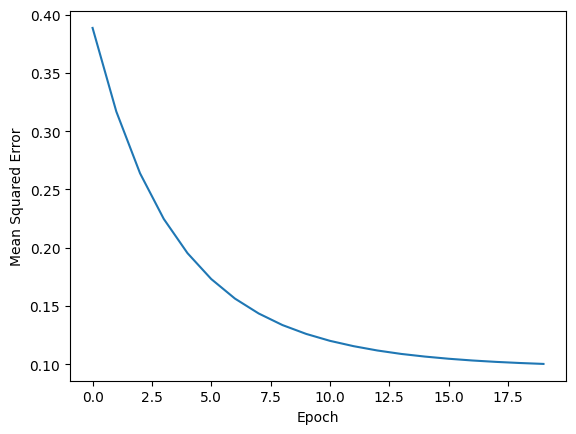

In [80]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show

In [81]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5,
                 ones,
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5,
                 ones,
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 92.86
Test Accuracy: 93.33
